In [1]:
from utils import *
from dataset import *
from autoencoder import *

Ashley = False
if Ashley:
    device = "cpu"
else:
    device = "cuda"

In [2]:
# Create dataset
N = 4096
B = 1024
unique_k_list = [1,0.5,0.25]
data = StepFunctionEventsDatasetFixedTime(N, unique_k_list)
loader = DataLoader(data, batch_size=B, shuffle=True, num_workers=4, collate_fn=padding_collate_fn)

In [3]:
# Create NN model
num_freqs = 6
num_latent = 10
model = AutoencoderRNN(num_latent, 2*num_freqs+1, 1, lam_TV = 0.5, lam_latent=0.1)
logger = TensorBoardLogger("lightning_logs", name="autoencoder")
trainer = pl.Trainer(max_epochs=50, accelerator=device, devices=1, plugins=[DisabledSLURMEnvironment(auto_requeue=False)], log_every_n_steps=8, logger=logger)
history = trainer.fit(model, loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params
------------------------------------------------------
0 | encoder_lstm   | LSTM               | 20.2 K
1 | encoder_linear | Linear             | 650   
2 | decoder        | ResnetFC           | 26.6 K
3 | code           | PositionalEncoding | 0     
------------------------------------------------------
47.4 K    Trainable params
0         Non-trainable params
47.4 K    Total params
0.190     Total estimated model params size (MB)
/nobackup/users/yankeson/miniconda3/envs/DL/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=8). Set a lower value for log_every_n_steps if you want to see logs for the training ep

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [4]:
# Visualize training, not working on my cluster, trying to figure out why
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [30]:
# Test data, currently just the training data
test_loader = DataLoader(data, batch_size=N, collate_fn=padding_collate_fn)
test_batch = next(iter(test_loader))
model.eval()
with torch.no_grad():
    model.encode(model.code(test_batch['event_list']))
    z = model.latent.cpu().numpy()

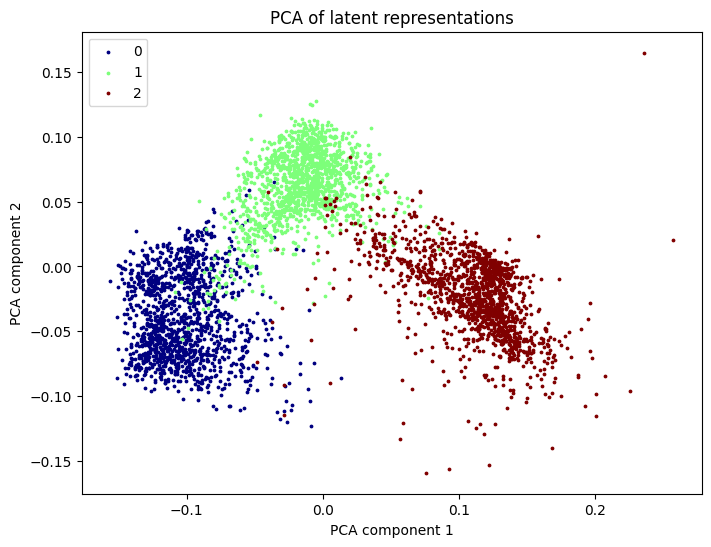

In [31]:
##### PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding = pca.fit_transform(z)

labels = test_batch['type'].numpy()
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.scatter(embedding[idx, 0], embedding[idx, 1], color=colors[i], label=label, marker='o',s=3)

plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.legend(loc='best')
plt.title('PCA of latent representations')
plt.show()

Using current time as random seed...
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 0 of 4096
Input similarities computed in 0.53 seconds (sparsity = 0.028411)!
Learning embedding...
Iteration 50: error is 84.416806 (50 iterations in 2.05 seconds)
Iteration 100: error is 70.258583 (50 iterations in 1.87 seconds)
Iteration 150: error is 68.159847 (50 iterations in 1.82 seconds)
Iteration 200: error is 67.313420 (50 iterations in 2.11 seconds)
Iteration 250: error is 3.091977 (50 iterations in 1.85 seconds)
Iteration 300: error is 1.892246 (50 iterations in 1.63 seconds)
Iteration 350: error is 1.507701 (50 iterations in 1.60 seconds)
Iteration 400: error is 1.318476 (50 iterations in 1.63 seconds)
Iteration 450: error is 1.210918 (50 iterations in 1.63 seconds)
Iteration 500: error is 1.144687 (50 iterations in 1.65 seconds)
Iteration 550: error is 1.103667 (50 iterations in 1.64 seconds)
Iteration 600: error is 

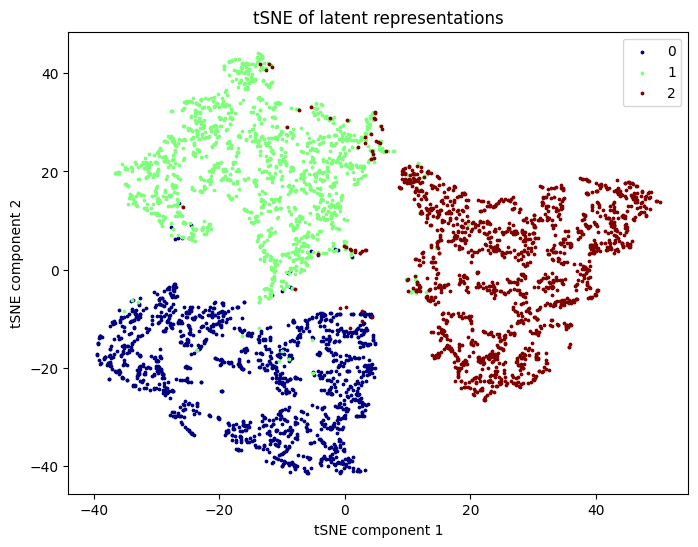

In [38]:
##### t-SNE
from bhtsne import tsne
data_nd_tsne = tsne(z.astype(np.float64))

labels = test_batch['type'].numpy()
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.scatter(data_nd_tsne[idx, 0], data_nd_tsne[idx, 1], color=colors[i], label=label, marker='o',s=3)

plt.xlabel('tSNE component 1')
plt.ylabel('tSNE component 2')
plt.legend(loc='best')
plt.title('tSNE of latent representations')
plt.show()

[[ 0.09529255  0.13336375  0.14708592 ...  0.06203333  0.13785687
  -0.20702903]
 [-0.11818726  0.15320401  0.08043934 ...  0.08110657  0.15263364
  -0.0913782 ]
 [-0.01000227  0.03496616 -0.01266398 ... -0.00879728  0.06947808
   0.06366849]
 ...
 [-0.04448191  0.05936087  0.12931168 ... -0.00657767 -0.00939508
   0.07422553]
 [-0.05498135  0.0526276   0.12878901 ... -0.0239429  -0.01369602
   0.11949193]
 [-0.05433866  0.05685611  0.13625503 ... -0.01369739 -0.00866005
   0.11185113]]


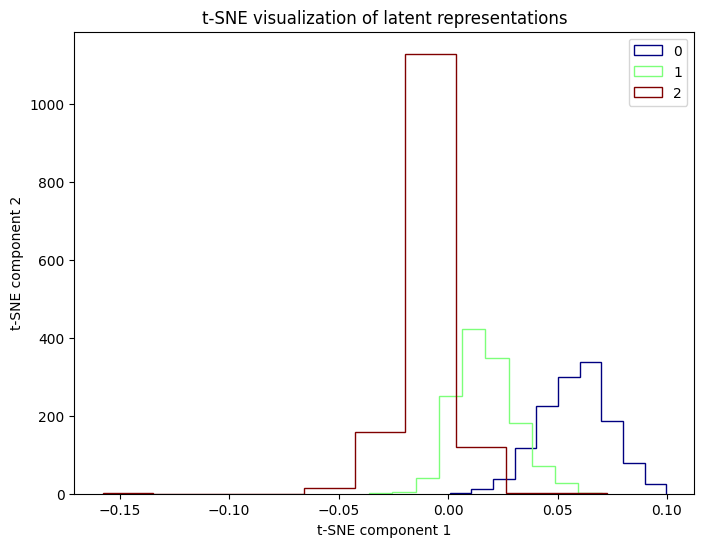

In [36]:
labels = test_batch['type'].numpy()
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
print(z)
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.hist(z[idx, 3], color=colors[i], histtype='step', label=label)

plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend(loc='best')
plt.title('t-SNE visualization of latent representations')
plt.show()

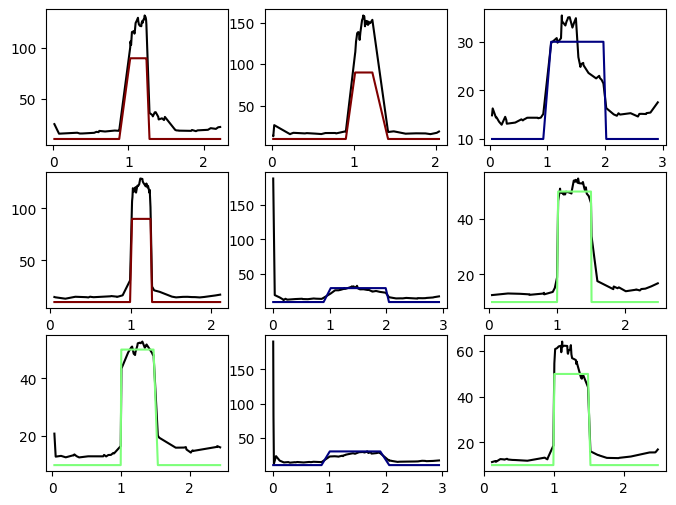

In [37]:
# Visualize the rate function that the NN has learned.
with torch.no_grad():
    coded = model.code(test_batch['event_list'])
    rates = model.decode(coded)
    
# Calculate true rates
labels = test_batch['type'].numpy()
k_list = torch.tensor([1,0.5,0.25])[labels].unsqueeze(-1)
true_rates = 10 + 20 / k_list * (coded[:,:,0] >= 1) * (coded[:,:,0] <= (1+k_list))

masks = test_batch['mask']
plt.figure(figsize=(8,6))
for index in range(9):
    plt.subplot(3,3,index+1)
    plt.plot(coded[index,masks[index],0], torch.exp(rates[index,masks[index],0]),color='k')
    plt.plot(coded[index,masks[index],0], true_rates[index,masks[index]], color = colors[labels[index]])